In [1]:
from qiskit import QuantumCircuit,Aer,execute
from qiskit.quantum_info import Statevector
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_bloch_multivector,plot_histogram,plot_state_qsphere
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from math import *
import random as rdm

import matplotlib.pyplot as plt

In [2]:
backend_s = Aer.get_backend('statevector_simulator')
backend_q = Aer.get_backend('qasm_simulator')

prov = IBMQ.load_account()
backend_vigo = prov.get_backend('ibmq_vigo')
noise_m = NoiseModel.from_backend(backend_vigo)

D:\Coding\myPython\WPy64-3760\python-3.7.6.amd64\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# QOSF Mentorship Program: TASK 2
### Implement a circuit that returns $\mid{0}{1}\rangle$ and $\mid{1}{0}\rangle$ with equal probability (50% for each).
#### Requirements:
1. The circuits should consist only of CNOTs, RXs and RYs.
2. Start from all parameters in parametric gates being equal to zero or randomly chosen.
3. You should find the right set of paramaeters using gradient descent (you can use more advanced optimisation methods if you like).
4. Simulations must be done with sampling (i.e. limited number of measurements per iterations and noise).

Compare the results for different numbers of measurements: 1, 10, 100, 1000

# My Approach to the Solution

From the question we can understand that the state we end up with should be of the form:
$\normalsize|\psi\rangle = \alpha|01\rangle + \beta|10\rangle$,

where $\normalsize\lVert\alpha\lVert{^2}=\frac{1}{2}$ and $\normalsize\lVert\beta\lVert{^2}=\frac{1}{2}$ and $\large\alpha,\beta\in C{^2}$

The required state resembles one of the four Bell Bases, commonly cited as examples of a pair of entangled qubits.

We are allowed to use the following gates:

$\normalsize R_x(\theta) = \begin{bmatrix}\cos(\frac\theta2) & -isin(\frac\theta2) \\-isin(\frac\theta2) & cos(\frac\theta2) \end{bmatrix}$

$\normalsize R_y(\theta) = \begin{bmatrix}\cos(\frac\theta2) & -sin(\frac\theta2) \\sin(\frac\theta2) & cos(\frac\theta2) \end{bmatrix}$

$\normalsize CNOT = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}$

For visual reference, let us generate a circuit with 2 qubits, each acted upon by the above gates $\normalsize (R_x(\theta), R_y(\theta)$ and $CNOT)$, initialized with random angles of rotation.

In [3]:
# store initial random states of Rx and Ry gates
theta_0 = []
theta_1 = []
theta_0.append(rdm.uniform(0,2*pi))
theta_0.append(rdm.uniform(0,2*pi))
theta_1.append(rdm.uniform(0,2*pi))
theta_1.append(rdm.uniform(0,2*pi))
theta_0, theta_1

([3.665068375288861, 3.8980783091249562],
 [3.768969423728698, 0.8842788755813902])

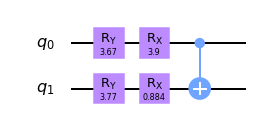

In [4]:
ref_circuit = QuantumCircuit(2)
ref_circuit.ry(theta_0[0],0)
ref_circuit.rx(theta_0[1],0)
ref_circuit.ry(theta_1[0],1)
ref_circuit.rx(theta_1[1],1)
ref_circuit.cx(0,1)

ref_circuit.draw('mpl')

As evident we need to tune the 4 angles we are dealing with in order to produce our target state. Instead of working with all four at a time, we can use the reversibility property of gates in quantum circuits to our advantage and simplify the problem. We know the target state has to be of the form $\normalsize\alpha|01\rangle + \beta|10\rangle$, which is obtained by a $\normalsize CNOT$ operation preceding the final state.

This means if we apply the $\normalsize CNOT$ on $\normalsize |\psi\rangle$, we will get the state that was just before $\normalsize |\psi\rangle$

$\large|\psi'\rangle\normalsize = CNOT |\large\psi\rangle = \alpha|01\rangle + \beta|11\rangle$

We can further "factorize" this state and obtain the states in which both qubits $\normalsize q_0$ and $\normalsize q_1$are.

$\large|\psi'\rangle = (\alpha|0\rangle + \beta|1\rangle) \otimes |1\rangle$

From this we can safely infer that just before the final $CNOT$ is applied, $\normalsize q_1$ was in the state $\normalsize|1\rangle$

Now our job is to achieve the individual states of $\normalsize q_0$ and $\normalsize q_1$ using gradient descent on the parameters of each qubit's $\normalsize R_x$ and $\normalsize R_y$ gates.

$\Large q_0$

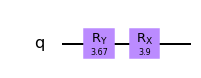

In [5]:
q0_circuit = QuantumCircuit(1)
q0_circuit.ry(theta_0[0],0)
q0_circuit.rx(theta_0[1],0)
q0_circuit.draw('mpl')

$\Large q_1$

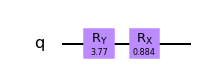

In [6]:
q1_circuit = QuantumCircuit(1)
q1_circuit.ry(theta_1[0],0)
q1_circuit.rx(theta_1[1],0)
q1_circuit.draw('mpl')

$\Large-------------------------------------$

Let's do a little mathematics in order to determine the cost functions and the gradients to update our parameters with.

Qubits are by default initialized in $\normalsize |0\rangle = \begin{bmatrix} 1 & 0 \end{bmatrix}{^T}$

## The math for $q_0$

The final state of the above circuit will be achieved by the following operation:

$\large
R_x(\theta_{1})\times
R_y(\theta_{0})\times
|0\rangle$

$\normalsize
=
\begin{bmatrix}
cos(\frac{\theta_{1}}{2}) & -isin(\frac{\theta_{1}}{2})
\\
-isin(\frac{\theta_{1}}{2}) & cos(\frac{\theta_{1}}{2})
\end{bmatrix}
\begin{bmatrix}
cos(\frac{\theta_{0}}{2}) & -sin(\frac{\theta_{0}}{2})
\\
sin(\frac{\theta_{0}}{2}) & cos(\frac{\theta_{0}}{2})
\end{bmatrix}
\begin{bmatrix}
1
\\
0
\end{bmatrix}$

$\normalsize
=
\begin{bmatrix}
cos(\frac{\theta_{1}}{2})cos(\frac{\theta_{0}}{2})
-isin(\frac{\theta_{1}}{2})sin(\frac{\theta_{0}}{2})
\\
cos(\frac{\theta_{1}}{2})sin(\frac{\theta_{0}}{2})
-isin(\frac{\theta_{1}}{2})cos(\frac{\theta_{0}}{2})
\end{bmatrix}
=
\normalsize\begin{bmatrix}
\alpha
\\
\beta
\end{bmatrix}$

By matrix equality rules, all corresponding elements of equal matrices must be equal. Hence

$\large
cos(\frac{\theta_{1}}{2})\cdot
cos(\frac{\theta_{0}}{2})
-
isin(\frac{\theta_{1}}{2})\cdot
sin(\frac{\theta_{0}}{2})
=
\alpha$

and

$\large
cos(\frac{\theta_{1}}{2})\cdot 
sin(\frac{\theta_{0}}{2})
-
isin(\frac{\theta_{1}}{2})\cdot
cos(\frac{\theta_{0}}{2})
=
\beta$

Equating the magnitudes we get

$\large
cos{^2}(\frac{\theta_{1}}{2})\cdot
cos{^2}(\frac{\theta_{0}}{2})
+
sin{^2}(\frac{\theta_{1}}{2})\cdot
sin{^2}(\frac{\theta_{0}}{2})
=
\lVert\alpha\lVert{^2}
= 
\frac{1}{2}$

$\large
cos{^2}(\frac{\theta_{1}}{2})\cdot
sin{^2}(\frac{\theta_{0}}{2})
+
sin{^2}(\frac{\theta_{1}}{2})\cdot
cos{^2}(\frac{\theta_{0}}{2})
=
\lVert\beta\lVert{^2}
=
\frac{1}{2}$

We know that
$\normalsize\lVert\alpha\lVert{^2}$
represents the probability of measuring qubit
$\normalsize q_0$
in the
$\normalsize|0\rangle$
state, and
$\lVert\beta\lVert{^2}$
represents probability of obtaining
$\normalsize|1\rangle$
upon measurement.

Let these be
$\normalsize P_{0}$
and
$\normalsize P_{1}$
respectively. For qubit
$\normalsize q_0$,
We require these values to be

$\normalsize
P_{0} = \large\frac{1}{2}$
and
$\normalsize
P_{1} = \large\frac{1}{2}$

## The math for $q_1$

As in the above case,

$\large
R_x(\theta_{1})\times
R_y(\theta_{0})\times
|0\rangle
\normalsize
=
\begin{bmatrix}
cos(\frac{\theta_{1}}{2})cos(\frac{\theta_{0}}{2})
-isin(\frac{\theta_{1}}{2})sin(\frac{\theta_{0}}{2})
\\
cos(\frac{\theta_{1}}{2})sin(\frac{\theta_{0}}{2})
-isin(\frac{\theta_{1}}{2})cos(\frac{\theta_{0}}{2})
\end{bmatrix}
=
\begin{bmatrix}
0
\\
\beta
\end{bmatrix}
$

where 
$\normalsize\lVert\beta\lVert{^2} = 1$,
because we know that
$\normalsize q_1$
must certainly be in state 
$\large|1\rangle.$

$\large
cos{^2}(\frac{\theta_{1}}{2})\cdot
cos{^2}(\frac{\theta_{0}}{2})
+
sin{^2}(\frac{\theta_{1}}{2})\cdot
sin{^2}(\frac{\theta_{0}}{2})
=
0$

$\large
cos{^2}(\frac{\theta_{1}}{2})\cdot
sin{^2}(\frac{\theta_{0}}{2})
+
sin{^2}(\frac{\theta_{1}}{2})\cdot
cos{^2}(\frac{\theta_{0}}{2})
=
1$

Following the notation introduced above, we require

$\normalsize
P_{0} = 0$
and
$\normalsize
P_{1} = 1
$

$\Large-------------------------------------$

## Gradient Descent

A little introduction to gradient descent. Gradient Descent is an iterative optimisation algorithm which uses a cost function of the parameters and the uses gradient of the cost function with respect to each of the parameters to update the parameters to "better" values. This is done until the difference between the costs in successive iterations is below a pre-defined limit, or for a pre-defined number of iterations.

In simple terms the "cost" function is a measure of how close to the target our parameters take us. Hence it follows that cost function must be low if we are close to our required parameters, and high if we are far away.

By this logic, a suitable cost function
$\normalsize (Z_0)$
for the
$\normalsize q_0$
circuit would be

$\normalsize
Z_0
=
(P_{0}-\frac{1}{2}){^2} + (P_{1}-\frac{1}{2}){^2}
\\
\normalsize
= 2(P_{0}-0.5){^2}
= 2(P_{1}-0.5){^2}
$

and the cost function
$\normalsize
(Z_1)$
for
$\normalsize
q_1$
would be

$\normalsize
Z_1
=
(P_{0}){^2}
+
(P_{1}-1){^2}
\\
\normalsize
= 2(P_{0}){^2} = 2(P_{1}-1){^2}
$

The differentiation of the cost functions must be done with respect to the parameters
$\normalsize
\theta_{0}$
and
$\normalsize
\theta_{1}
$

$\Large
\frac{\partial Z_{0}}{\partial P_{0}}
=
\normalsize
4(P_{0}-0.5)
\huge|
\Large
\frac{\partial Z_{0}}{\partial P_{1}}
=
\normalsize
4(P_{1}-0.5)
$

$\Large
\frac{\partial Z_{1}}{\partial P_{0}}
=
\normalsize
4(P_{0})
\huge|
\Large
\frac{\partial Z_{1}}{\partial P_{1}}
=
\normalsize
4(P_{1}-1)
$

We arrive at the derivatives of the cost functions with respect to the parameters by manipulating using the chain rule.

$\Large
\frac{\partial Z_{0}}{\partial\theta_{0}}
=
\normalsize
sin(\theta_{0})\cdot
cos(\theta_{1})\cdot
(P_{1} - P_{0})
$

$\Large
\frac{\partial Z_{0}}{\partial\theta_{1}}
=
\normalsize
sin(\theta_{1})\cdot
cos(\theta_{0})\cdot
(P_{1} - P_{0})
$

$\Large
\frac{\partial Z_{1}}{\partial\theta_{0}}
=
\normalsize
sin(\theta_{0})\cdot
cos(\theta_{1})\cdot
(P_{1} - P_{0} - 1)
$

$\Large
\frac{\partial Z_{1}}{\partial\theta_{0}}
=
\normalsize
sin(\theta_{1})\cdot
cos(\theta_{0})\cdot
(P_{1} - P_{0} - 1)
$

The updation of parameters for gradient descent will be done using the following rule:

$\large
\widetilde\theta_{i}
=
\theta_{i}
-
\in\cdot
\Large
\frac
{\partial(Z_i)}{\partial\theta_{i}}
$

where $\normalsize\in$ is the "learning rate", a specification to decide the pace with which the optimization approaches the optimal values.
Too high a learning rate might overshoot the optimal set of parameters and too low a learning rate may take longer than the specified iterations.

$\Large-------------------------------------$

# Implementation

We need to build functions that will calculate cost, update parameters, create the new updated circuit and execute the circuit and return results.

* Intializing parameters and building initial circuit

In [7]:
def getInitial():
    t = [rdm.uniform(0,2*pi), rdm.uniform(0,2*pi)]
    return t

def create_ckt_single(thetas):
    qc = QuantumCircuit(1)
    qc.ry(thetas[0],0)
    qc.rx(thetas[1],0)
    qc.measure_all()
    return qc

* Execute circuit and get probabilities

In [8]:
def getProbs(circuit, bkd, shots):
    if bkd == backend_q:
        use_noise = noise_m
    else:
        use_noise = None
        
    result = execute(circuit,bkd,shots=shots,noise_model=use_noise).result()
    if bkd==backend_q:
        probs = result.get_counts()
    elif bkd==backend_s:
        probs = Statevector(result.get_statevector()).probabilities_dict()
    
    try:
        p0 = probs['0']/shots
    except:
        p0 = 0
    try:
        p1 = probs['1']/shots
    except:
        p1 = 0
    
    return p0,p1

* Cost function functions

In [9]:
# cost for qubit q0
def getCost0(prob0,prob1):
    return 2*((prob0-0.5)**2)

# cost for qubit q1
def getCost1(prob0,prob1):
    return 2*(prob0**2)

* Calculating gradients

In [10]:
# d(Z0)/d(theta_0)
def grad_Z0T0(thetas,prob0,prob1):
    g = (prob1-prob0)*(sin(thetas[0])*cos(thetas[1]))
    return g

# d(Z0)/d(theta_1)
def grad_Z0T1(thetas,prob0,prob1):
    g = (prob1-prob0)*(sin(thetas[1])*cos(thetas[0]))
    return g

# d(Z1)/d(theta_0)
def grad_Z1T0(thetas,prob0,prob1):
    return (prob1-prob0-1)*(sin(thetas[0])*cos(thetas[1]))

# d(Z1)/d(theta_1)
def grad_Z1T1(thetas,prob0,prob1):
    return (prob1-prob0-1)*(sin(thetas[1])*cos(thetas[0]))

* Updating parameters

In [11]:
def parameter_update(thetas,p0,p1,lr,qb):
    if qb==0:
        thetas[0] = thetas[0] - lr*grad_Z0T0(thetas,p0,p1)
        thetas[1] = thetas[1] - lr*grad_Z0T1(thetas,p0,p1)
        return thetas
    else:
        thetas[0] = thetas[0] - lr*grad_Z1T0(thetas,p0,p1)
        thetas[1] = thetas[1] - lr*grad_Z1T1(thetas,p0,p1)
        return thetas

In [12]:
def run_Gradient_Descent(shots,iterations,lr,qubit):
    if qubit == 0:
        costF = getCost0
    elif qubit == 1:
        costF = getCost1
    # initialize random parameters- theta_0 for gates on q0, theta_1 for gates on q1
    theta = getInitial()
    
    # Store costs over the iterations
    all_costs = []
    
    for i in range(iterations):
        # construct the circuit for single qubit
        ckt_q = create_ckt_single(theta)
        # execute and get probabilities from result
        p0,p1 = getProbs(ckt_q,backend_q,shots)
        # get cost associated with p0,p1
        curr_cost = costF(p0,p1)
        all_costs.append(curr_cost)
        # update parameters
        theta = parameter_update(theta,p0,p1,lr,qubit)
    
    ckt_q = create_ckt_single(theta)
    return ckt_q, theta, all_costs

All the supporting functions are ready now. Let us run it for the various number of shots required and plot the single qubit results.

$\Large-------------------------------------$

In [13]:
# list of shots to run over
shotlist = [1,10,100,1000]
# iterations for each gradient descent
iterations = 1000
# learning rate
learn_rate = 0.01
# qubits (q0, q1)
qubits = [0,1]

Run Gradient Descent according to above parameters and store the results

In [14]:
results_0 = []
results_1 = []
for shot in shotlist:
    ckt,angles,costs = run_Gradient_Descent(shot,iterations,learn_rate,0)
    results_0.append({'shots': shot,'circuit': ckt,'angles': angles,'costs': costs})
    ckt,angles,costs = run_Gradient_Descent(shot,iterations,learn_rate,1)
    results_1.append({'shots': shot,'circuit': ckt,'angles': angles,'costs': costs})

Function to plot the results

In [15]:
def plot_results(results,iterations,qubit):
    fig,p1 = plt.subplots(4,1)
    fig.set_size_inches(10,8)
    fig.set_tight_layout(5.0)
    shots = [1,10,100,1000]
    for i in range(len(results)):
        p = p1[i]
        p.plot(range(iterations), results[i]['costs'])
        sv = Statevector.from_label("0").evolve(results[i]['circuit'].remove_final_measurements(inplace=False))
        probs = sv.probabilities_dict()
        pb0 = probs['0'] if '0' in probs else 0
        pb1 = 1-pb0
        p.set_title("Cost vs Iterations for qubit {} | Shots: {} | Result: P0 = {:.5f} ; P1 = {:5f}".format(qubit,shots[i],pb0,pb1))

### Results for $\normalsize q_0$

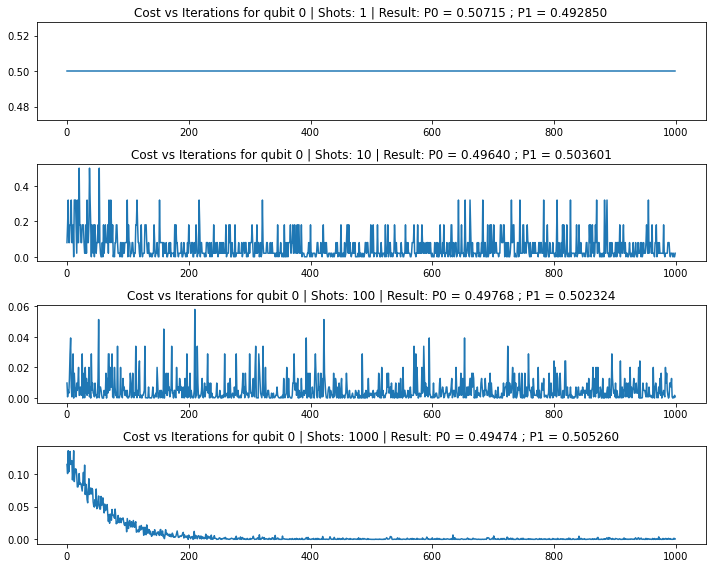

In [16]:
plot_results(results_0,iterations,0)

### Results for $\normalsize q_1$

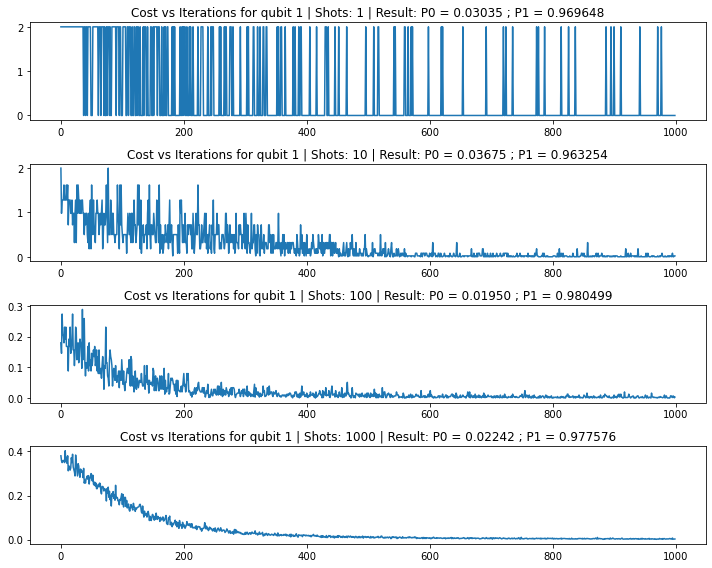

In [17]:
plot_results(results_1,iterations,1)

Now we combine the two single circuits with the help of the following function, and plot the histograms of the results of execution of the circuits.

In [18]:
def create_ckt_combined(theta_0,theta_1):
    qc = QuantumCircuit(2)
    qc.ry(theta_0[0],0)
    qc.rx(theta_0[1],0)
    qc.ry(theta_1[0],1)
    qc.rx(theta_1[1],1)
    qc.cx(0,1)
    return qc

In [19]:
combined_ckts = []
combined_ckts_results_noisy = []
combined_ckts_results_noiseless = []
for i in range(len(results_0)):
    ckt = create_ckt_combined(results_0[i]['angles'],results_1[i]['angles'])
    ckt.measure_all()
    combined_ckts.append(ckt)
    res = execute(ckt,backend_q,shots=4096,noise_model=None).result()
    combined_ckts_results_noiseless.append(res)
    res = execute(ckt,backend_q,shots=4096,noise_model=noise_m).result()
    combined_ckts_results_noisy.append(res)

legend = ['Noiseless','Noisy']

### 1 Shot

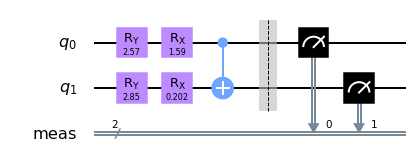

In [20]:
ckt = combined_ckts[0]
ckt.draw('mpl')

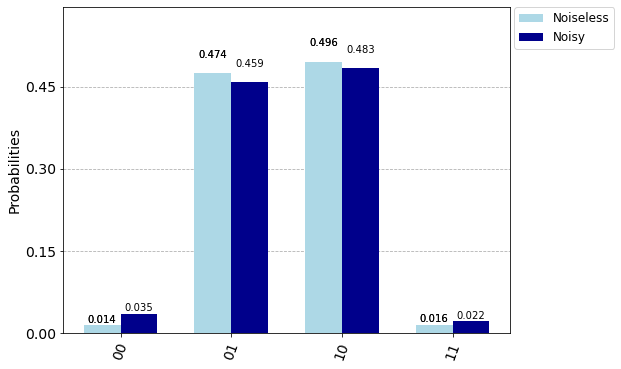

In [21]:
noisy = combined_ckts_results_noisy[0].get_counts()
noiseless = combined_ckts_results_noiseless[0].get_counts()
plot_histogram([noiseless,noisy],legend = legend,figsize = (8,6),color=['lightblue','darkblue'])

### 10 Shots

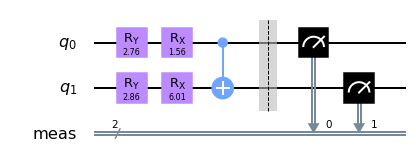

In [22]:
ckt = combined_ckts[1]
ckt.draw('mpl')

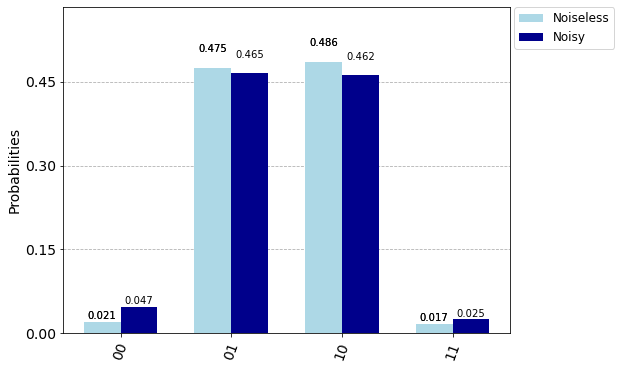

In [23]:
noisy = combined_ckts_results_noisy[1].get_counts()
noiseless = combined_ckts_results_noiseless[1].get_counts()
plot_histogram([noiseless,noisy],legend = legend,figsize = (8,6),color=['lightblue','darkblue'])

### 100 Shots

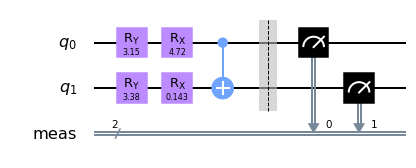

In [24]:
ckt = combined_ckts[2]
ckt.draw('mpl')

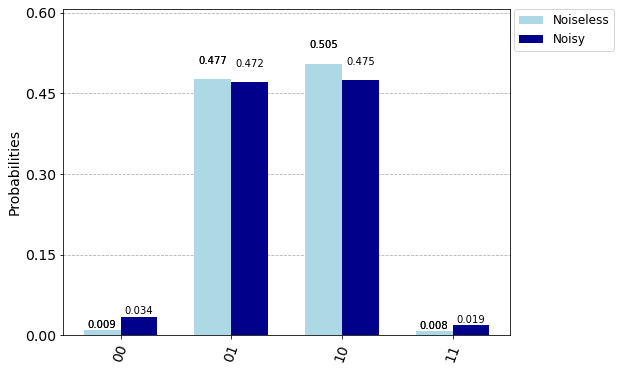

In [25]:
noisy = combined_ckts_results_noisy[2].get_counts()
noiseless = combined_ckts_results_noiseless[2].get_counts()
plot_histogram([noiseless,noisy],legend = legend,figsize = (8,6),color=['lightblue','darkblue'])

### 1000 Shots

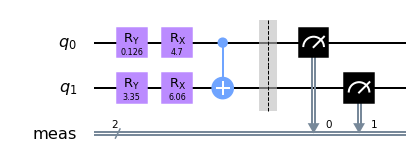

In [26]:
ckt = combined_ckts[3]
ckt.draw('mpl')

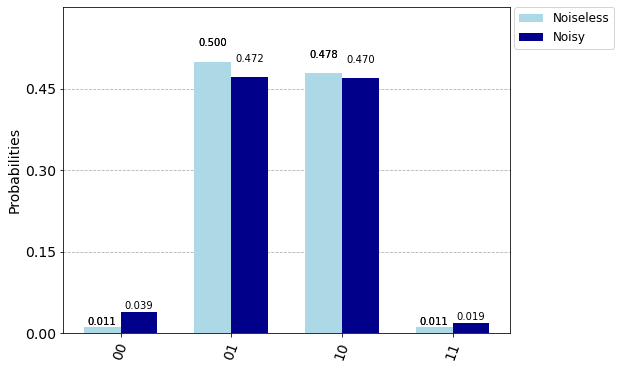

In [27]:
noisy = combined_ckts_results_noisy[3].get_counts()
noiseless = combined_ckts_results_noiseless[3].get_counts()
plot_histogram([noiseless,noisy],legend = legend,figsize = (8,6),color=['lightblue','darkblue'])

$\Large-------------------------------------$

We can see that our circuits successfully generate the required states without the presence of noise with nearly equal probabilities, as required. In the presence of noise, however, sometimes the "forbidden" states generated.

From the plots of the training cost values, we can see that when the iterations were run using 1 shot, the cost for
$\normalsize q_0$
is always 0.5. This is because our qubit 0's cost function is 
$\normalsize 2\times (P_0-0.5){^2}$, and with a single shot,
$\normalsize P_0$
can only be 0 or 1, causing the cost function to become a constant function for this case. Nevertheless, the final gradient descent-optimized values for the gates bring us as close to the target values as with higher number of shots.